In [11]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import os
import time
from tqdm import tqdm

def to_tensor(x):
    return x.transpose(2, 0, 1).astype('float32')

def eval_performance(ENCODER, ARCH):
    ENCODER_WEIGHTS = "imagenet"
    DEVICE = 'cuda'

    MODEL_PATH = f"best_model_{ARCH}_{ENCODER}.pth"

    model = torch.load(MODEL_PATH).to(DEVICE)
    model.eval()
    preprocessing = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    DATA_PATH = '../ExtractedData/dalmacija-large-128'
    filepaths = os.listdir(DATA_PATH)[:10]
    np_images = []
    for f in filepaths:
        img = cv2.imread(os.path.join(DATA_PATH, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_tensor = preprocessing(img)
        x_tensor = to_tensor(x_tensor)
        np_images.append(x_tensor)

    np_images = np.array(np_images)
    x_tensor = torch.from_numpy(np_images).to(DEVICE)
    times = []
    for i in range(100):
        start_time = time.perf_counter()
        model.predict(x_tensor)
        end_time = time.perf_counter()
        times.append(end_time-start_time)
    print(ARCH, ENCODER, sum(times)/len(times))

In [12]:
if __name__ == "__main__":
    ENCODERS = [
        'mobilenet_v2',
        'efficientnet-b0',
        #'timm-mobilenetv3_large_075'
    ]
    ARCHS = [
        'DeepLabV3Plus',
        'Link',
        'MANET',
        'PAN',
        'PSP',
        'UnetPlusPlus'
    ]

    for arch in ARCHS:
        for ENC in ENCODERS:
            eval_performance(ENC, arch)

DeepLabV3Plus mobilenet_v2 0.013273049820418237
DeepLabV3Plus efficientnet-b0 0.021935872780741193
Link mobilenet_v2 0.012463214859890286
Link efficientnet-b0 0.021314473379170522
MANET mobilenet_v2 0.016651275129552234
MANET efficientnet-b0 0.02540618562925374
PAN mobilenet_v2 0.014686717489676085
PAN efficientnet-b0 0.023534123349527362
PSP mobilenet_v2 0.0045484264090191575
PSP efficientnet-b0 0.006850984030315885
UnetPlusPlus mobilenet_v2 0.015388165151380235
UnetPlusPlus efficientnet-b0 0.02418573208124144


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap


/tmp/ipykernel_61/370364522.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel_cmap = get_cmap('tab10')


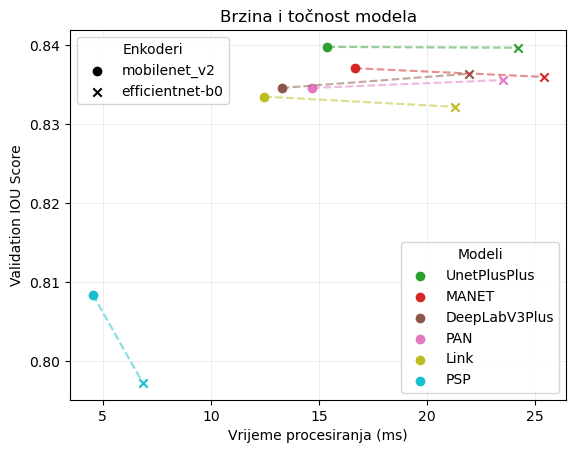

In [34]:
models = ['UnetPlusPlus', 'MANET', 'DeepLabV3Plus', 'PAN', 'Link', 'PSP']
encoders = ['mobilenet_v2', 'efficientnet-b0']
accuracy = np.array([[0.8398, 0.8397], [0.8371, 0.836], [0.8346, 0.8364], [0.8346, 0.8356], [0.8335, 0.8322], [0.8084, 0.7972]])
latency = np.array([[15.39, 24.19], [16.65, 25.4], [13.27, 21.93], [14.69, 23.53], [12.46, 21.31], [4.54, 6.85]])

pastel_cmap = get_cmap('tab10')
num_models = len(models)
colors = pastel_cmap(np.linspace(0.2, 1, num_models))
markers = ['o', 'x']

model_plot_objects = []
encoder_plot_objects = []
encoder_legend_objects = [
    plt.scatter([], [], color='black', marker=markers[i]) for i in range(len(encoders))
]

for i, model in enumerate(models):
    for j, encoder in enumerate(encoders):
        scatter_plot = plt.scatter(latency[i][j], accuracy[i][j], color=colors[i], marker=markers[j])
        
        if j == 0:
            model_plot_objects.append(scatter_plot)
        if i == 0:
            encoder_plot_objects.append(scatter_plot)
        plt.plot(latency[i], accuracy[i], linestyle='--', color=colors[i], alpha=0.3)


legend1 = plt.legend(model_plot_objects, models, title='Modeli', loc='lower right')
legend2 = plt.legend(encoder_legend_objects, encoders, title='Enkoderi', loc='best')
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2) 
# Add the first legend manually to the current Axes
plt.gca().add_artist(legend1)

plt.title('Brzina i točnost modela')
plt.xlabel('Vrijeme procesiranja (ms)')
plt.ylabel('Validation IOU Score')
plt.savefig('accuracy_vs_speed.png')
plt.show()

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)